# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.


| Member | Responsibility Area | Tasks to Complete | Expected Output |
|--------|----------------------|------------------|-----------------|
| **A — Dataset Setup & Directory Mapping** | Initialize dataset structure | - Validate root directory<br>- Scan fruit class folders<br>- Create `class_to_idx` mapping<br>- Build `samples = [(path, label), ...]` list<br>- Implement `__len__()` | `class_to_idx` dict + `samples` list populated |
| **B — Image Loading & Preprocessing** | Input image handling | - Read image using `cv2.imread`<br>- Convert BGR → RGB<br>- Generate grayscale copy<br>- Optional resize if team agrees | Function `load_image(path)` returns `(rgb, gray)` |
| **C — LBP Texture Processing** | Texture feature module | - Convert gray image to LBP representation<br>- Either LBP image or histogram<br>- Ensure consistent output format | Function `compute_lbp(gray)` returns LBP image |
| **D — Canny + Shape Features** | Edge + contour + shape features | - Apply Canny edge detection<br>- Find largest contour<br>- Extract 6 shape features:<br>1. Area (normed)<br>2. Aspect Ratio<br>3. Solidity<br>4. Circularity<br>5. Hu Moment 1<br>6. Hu Moment 2 | Function `compute_edges_and_shape(gray)` returns `(edges_img, shape_vector)` |
| **E — HSV Color Features** | Color feature module | - Convert image to HSV<br>- Compute Mean & Std of H, S, V<br>- 6 color features = `[Hμ, Hσ, Sμ, Sσ, Vμ, Vσ]` | Function `compute_color_features(rgb)` returns 6-value list/array |
| **F — Final Assembly (`__getitem__`)** | Data packaging & return structure | - Call helper functions (B–E)<br>- Package outputs into a `dict`<br>- Keep code clean and minimal | Complete `__getitem__` returning `{image, lbp, edges, color, shape, label}` |


In [3]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class FruitsDataset(Dataset):
    def __init__(self, root_dir):
        self.root = root_dir

        # TEAM MEMBER A — directory scan & label mapping
        self.class_to_idx = {}
        self.samples = []

        lbl = 0
        for folder in os.listdir(root_dir):
            class_path = os.path.join(root_dir, folder)
            if os.path.isdir(class_path):
                self.class_to_idx[folder] = lbl
                for img in os.listdir(class_path):
                    self.samples.append((os.path.join(class_path, img), lbl))
                lbl += 1

    def __len__(self):
        return len(self.samples)

    # TEAM MEMBER B — Image Loader
    def load_image(self, path):
        bgr = cv2.imread(path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        #This is the greyscale copy
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        return rgb, gray

    # TEAM MEMBER C — LBP (simple neighborhood compare)
    def compute_lbp(self, gray):
        lbp = np.zeros_like(gray)
        for i in range(1, gray.shape[0]-1):
            for j in range(1, gray.shape[1]-1):
                center = gray[i,j]
                code = 0
                code |= (gray[i-1,j-1] >= center) << 7
                code |= (gray[i-1,j  ] >= center) << 6
                code |= (gray[i-1,j+1] >= center) << 5
                code |= (gray[i,  j+1] >= center) << 4
                code |= (gray[i+1,j+1] >= center) << 3
                code |= (gray[i+1,j  ] >= center) << 2
                code |= (gray[i+1,j-1] >= center) << 1
                code |= (gray[i,  j-1] >= center) << 0
                lbp[i,j] = code
        return lbp

    # TEAM MEMBER D — Canny + Shape Features
    def compute_edges_and_shape(self, gray):
        edges_img = cv2.Canny(gray, 100, 200)
        contours, _ = cv2.findContours(edges_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            return edges_img, [0]*6

        fruit = max(contours, key=cv2.contourArea)

        image_area = gray.shape[0] * gray.shape[1]
        area = cv2.contourArea(fruit)
        norm_area = area / image_area

        x, y, w, h = cv2.boundingRect(fruit)
        aspect_ratio = w / h

        hull = cv2.convexHull(fruit)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area != 0 else 0

        perimeter = cv2.arcLength(fruit, True)
        circularity = 4 * np.pi * area / (perimeter ** 2 + 1e-5)

        hu = cv2.HuMoments(cv2.moments(fruit)).flatten()
        hu1, hu2 = hu[0], hu[1]

        shape_vector = [norm_area, aspect_ratio, solidity, circularity, hu1, hu2]
        return edges_img, shape_vector

    # TEAM MEMBER E — HSV Color Features
    def compute_color_features(self, rgb):
        hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)

        feats = [
            float(np.mean(h)), float(np.std(h)),
            float(np.mean(s)), float(np.std(s)),
            float(np.mean(v)), float(np.std(v))
        ]
        return feats

    # TEAM MEMBER F — Final Output
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        rgb, gray = self.load_image(img_path)

        lbp = self.compute_lbp(gray)
        edges, shape_feats = self.compute_edges_and_shape(gray)
        color_feats = self.compute_color_features(rgb)

        return {
            "image": rgb,
            "lbp": lbp,
            "edges": edges,
            "color": color_feats,
            "shape": shape_feats,
            "label": label
        }

In [4]:
text = '{"username":"ponishbhatia","key":""}'
with open('kaggle.json', 'w') as f:
    f.write(text)

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!cat ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 4.89G/4.90G [00:58<00:00, 142MB/s]
100% 4.90G/4.90G [00:58<00:00, 89.8MB/s]


In [ ]:
# @title
!unzip /content/fruits.zip -d /content/Fruits-360

In [13]:
!ls Fruits-360

fruits-360_100x100	   fruits-360_dataset_meta  fruits-360_original-size
fruits-360_3-body-problem  fruits-360_multi


In [14]:
dataset = FruitsDataset("Fruits-360/fruits-360_100x100/fruits-360/Training")
sample = dataset[0]
for k,v in sample.items():
    print(k, type(v))

image <class 'numpy.ndarray'>
lbp <class 'numpy.ndarray'>
edges <class 'numpy.ndarray'>
color <class 'list'>
shape <class 'list'>
label <class 'int'>


In [24]:
sample = dataset[-20000]     # or any index
img     = sample["image"]
lbp     = sample["lbp"]
edges   = sample["edges"]
color   = sample["color"]
shape   = sample["shape"]
label   = sample["label"]

In [30]:
len(dataset)

124716

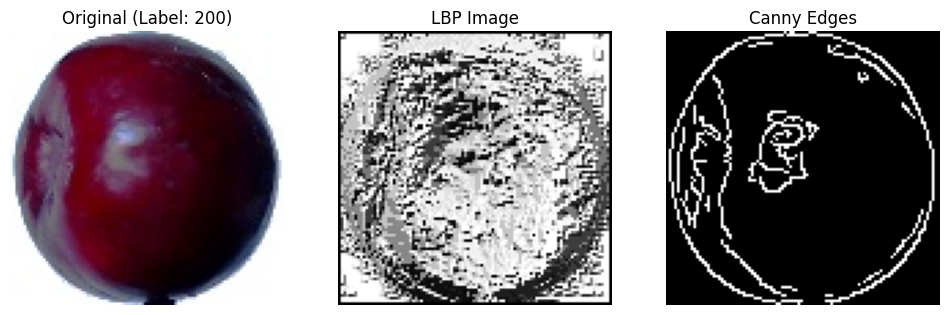

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title(f"Original (Label: {label})")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(lbp, cmap="gray")
plt.title("LBP Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edges")
plt.axis("off")

plt.show()

In [26]:
print("Color Features (HSV stats):")
print("H_mean, H_std, S_mean, S_std, V_mean, V_std =", color)

print("\nShape Features:")
print("Normalized Area, Aspect Ratio, Solidity, Circularity, Hu1, Hu2 =")
print(shape)

Color Features (HSV stats):
H_mean, H_std, S_mean, S_std, V_mean, V_std = [130.5942, 55.16876948383025, 146.092, 105.11087639250279, 117.9788, 82.8910812485879]

Shape Features:
Normalized Area, Aspect Ratio, Solidity, Circularity, Hu1, Hu2 =
[0.0077, 0.97, 0.009984439834024895, 0.0023651954274044474, np.float64(31.56817482099992), np.float64(12.54180498309723)]


In [27]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edges, shape_features = dataset.compute_edges_and_shape(gray)

In [29]:
feature_names = [
    "Normalized Area", "Aspect Ratio", "Solidity",
    "Circularity", "Hu Moment 1", "Hu Moment 2"
]

for name, value in zip(feature_names, shape_features):
    print(f"{name:20s}: {value}")

Normalized Area     : 0.0077
Aspect Ratio        : 0.97
Solidity            : 0.009984439834024895
Circularity         : 0.0023651954274044474
Hu Moment 1         : 31.56817482099992
Hu Moment 2         : 12.54180498309723


In [28]:
from torch.utils.data import DataLoader

In [32]:
def Fruits360_loader(path, batch_size=32, shuffle=True):
    train_dataset = FruitsDataset(path + "/Training")
    test_dataset  = FruitsDataset(path + "/Test")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_loader, test_loader

In [34]:

    train_loader, test_loader = Fruits360_loader("Fruits-360/fruits-360_100x100/fruits-360")
    print("Train samples:", len(train_loader.dataset))
    print("Test samples:", len(test_loader.dataset))

    batch = next(iter(train_loader))
    print("\nBatch keys:", batch.keys())
    print("Batch size:", len(batch["label"]))


Train samples: 124716
Test samples: 41577

Batch keys: dict_keys(['image', 'lbp', 'edges', 'color', 'shape', 'label'])
Batch size: 32
